# Semantische Melanomsegmentierung auf dem ISIC 2018 Datensatz mittels U-Net

Bei der semantischen Segmentierung wird jedem Pixel eines Bildes eine Klasse zugewiesen und das Bild so in verschiedene, inhaltlich zusammengehörige Bildregionen zusammengefasst. In diesem Beispiel werden Deep Learning basierte Methoden wie U-Nets für die automatische Melanomsegmentierung von Hautbildern verwendet.      

## Datensatz

Der [ISIC 2018 Task 1](https://challenge2018.isic-archive.com/task1/) Datensatz umfasst 2594 Hautbilder mit genau einer prmären Lesion (Hautveränderung) und 2594 zugehörige Segmentierungsmasken.

<img src="https://challenge.isic-archive.com/static/img/landing/2018/task1.png" width="600" />
Quelle: https://challenge2018.isic-archive.com/task1/

Für dieses Beispiel wird eine vorverarbeitete Version des "ISIC 2018 Task1"-Datensatzes mit 512 Pixeln Bildbreite verwendet, um das Einlesen der Bilddaten beim Training zu beschleunigen. Das Ziel des Modells besteht in der automatischen Erstellung einer binären Segmentierungsmasken für die Hautbilder (0=Hintergrund, 1=Lesion).

# 1. Imports und Setup

Der erste Schritt besteht in der Installation und dem Import der erforderlichen Python Packages. Falls die erfoderlichen Packages noch nicht installiert wurden, kann dies in der Shell z.B. über `pip install <package-name>` erfolgen. Getestet wurde dieses Beispiel mit den nachfolgend aufgeführten Packages: [Numpy 1.21.2](https://numpy.org/), [Pandas 1.4.2](https://pandas.pydata.org/), [Matplotlib 3.5.1](https://matplotlib.org/), [PyTorch 1.11.0](https://pytorch.org/), [segmentation-models-pytorch 0.2.1](https://github.com/qubvel/segmentation_models.pytorch), [torchinfo 1.6.5](https://github.com/TylerYep/torchinfo), [TorchMetrics 0.9.0](https://torchmetrics.readthedocs.io/en/stable/), [OpenCV-python 4.5.5.64](https://opencv.org/), [Albumentations 1.1.0](https://albumentations.ai/), [scikit-learn 1.0.2](https://scikit-learn.org/stable/index.html), [pkbar 0.5](https://github.com/yueyericardo/pkbar)

Im Gegensatz zu Tensorflow reserviert PyTorch immer nur so viel GPU-VRAM (Grafikspeicher), wie zur Ausführung des Codes benötigt wird. Verschiedene Faktoren beeinflussen die benötigte Menge an Grafikspeicher beim Training eines neuronalen Netzes, z.B. die Anzahl der Parameter (Gewichte) des neuronalen Netzes, die Minibatch-Größe, die Anzahl der Unterprozesse (worker) beim Laden von Daten etc. Mit `torch.cuda.set_per_process_memory_fraction(fraction: float)` kann PyTorch jedoch angewiesen werden, nur einen maximalen Anteil des verfügbaren Grafikspeichers für die Codeausführung zu verwenden, um beispielsweise mehrere Trainingsprozesse gleichzeitig auf einer GPU auszuführen.

In [1]:
import os, pkbar, tqdm, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss
from torchinfo import summary
from torchmetrics import MeanMetric, JaccardIndex, Precision, Recall, ConfusionMatrix

from sklearn.model_selection import train_test_split

# Limit the amount of available GPU-VRAM for code execution
#torch.cuda.set_per_process_memory_fraction(0.5)
torch.cuda.empty_cache()

# enable cudnn auto-tuner to find the best algorithms for the underlying hardware
torch.backends.cudnn.benchmark = True
torch.manual_seed(42) # set seed for reproducible results

## 1.1 Ordnerstruktur
Für dieses Beispiel sollten die folgenden Verzeichnisse angelegt werden:
- `ROOT_DIR`: Das Hauptverzeichnis in dem sich das Jupyter-Notebooks befindet (`os.getcwd()` ist hier hilfreich)
- `MODEL_DIR`: Verzeichnis in dem trainierte Modelle abgespeichert werden sollen
- `IMAGE_FILES`: Verzeichnis in dem sich die Hautbilder des Datensatzes befinden
- `MASK_FILES`: Verzeichnis in dem sich die Segmentierungsmasken zu den Hautbilder des Datensatzes befinden

In [ ]:
ROOT_DIR = os.path.abspath(os.getcwd()) # current path of the notebook
MODEL_DIR = os.path.join(ROOT_DIR, "models/segmentation/")
IMAGE_FILES = "./dataset/ISIC2018_Task1_512px/images/"
MASK_FILES = "./dataset/ISIC2018_Task1_512px/segmentations/"

print("Directories:")
print("Root directory:", ROOT_DIR)
print("Model directory:", MODEL_DIR)
print("Image files in directory:", IMAGE_FILES)
print("Ground Truth Mask files in directory:", MASK_FILES)

# 2. Datensatz

Es gibt viele verschiedene Möglichkeiten, Daten in PyTorch einzulesen. In diesem Beispiel definieren wir zunächst eine Dataset-Klasse, die die Hautbilder und die zugehörigen Segmentierungsmasken aus Listen mit Dateinamen `image_files` und `mask_files` einliest, vorverarbeitet und augmentiert. Dies geschieht mit der Methode `__getitem__(index)`, die über den Parameter `index` ein Hautbild mit Segmentierungsmaske aus der Liste der Dateinamen auswählt, vorverarbeitet und zurückgibt. 

Weitere Details zur Erstellung individueller Datensätze in PyTorch finden Sie unter dem Link: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

### Dataset-Klasse definieren

In [3]:
class ISIC2018Task1_Dataset(Dataset):
    def __init__(self, image_files:list, mask_files:list , transform=None):
        self.image_files = image_files # list of image filenames
        self.mask_files = mask_files # list of mask filenames
        self.transform = transform # albumentation augmentation pipeline

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_file = self.image_files[index]
        mask_file = self.mask_files[index]
        
        # load image and mask files as numpy array using opencv
        img = cv2.cvtColor(cv2.imread(img_file, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE) // 255  # normalize mask pixels to [0,1] since not done in albumentation pipeline

        # image and mask albumentation augmentation pipeline 
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        return (img, mask)

### Vorverarbeitungs-/ Augmentationpipeline definieren
Vorverarbeitungsschritte sowie Transformationsmöglichkeiten zur Datenerweiterung werden in diesem Beispiel in Form einer Vorverarbeitungspipeline `A.Compose` des Albumentations Packages verkettet und als `transform`-Parameter an die Dataset-Klasse übergeben. Details zu den Transformations- und Vorverarbeitungsschritten sind unter dem Link [Albumentations](https://albumentations.ai/) zu finden und können später zur Optimierung genutzt werden.

Die Vorverarbeitungsschritte für die Validierungsdaten unterscheiden sich von denen für die Trainingsdaten, bei denen zusätzlich Data-Augmentation durchgeführt wird. Daher werden im Folgenden zwei separate Vorverarbeitungspipelines für die Validierungs- und Trainingsdaten erstellt. Der Parameter `IMAGE_SIZE` definiert die quadratische Bildgröße der Hautbilder und Segmentierungsmasken für das Training. Eine kleinere Bildgröße hat den Effekt einer kürzeren Trainingszeit, führt aber auch zu einem Verlust an Bildinformationen.  

In [4]:
IMAGE_SIZE = 224
 
# albumentation pre-processing and augmentation pipeline for the training images 
train_transform = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Flip(p=0.5),
        A.GridDistortion(num_steps=5, distort_limit=0.3, border_mode=0, value=0, mask_value=0, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=45, border_mode=0, value=0, mask_value=0, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

# albumentation pre-processing pipeline for the validation images 
valid_transform = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

### Trainings- und Validerungsdatensatz initialisieren

Um den "ISIC 2018 Task 1"-Datensatz aufzuteilen, werden zunächst alle Dateipfade der Hautbilder aus dem Ordner `IMAGE_FILES` und der Segmentierungsmasken aus dem Ordner `MASK_FILES` mit dem [glob](https://docs.python.org/3/library/glob.html) Package in die Listen `image_files` und `mask_files` aufgelistet. Mit `'*.jpg'`/ `'*.png'` listet glob nur Dateien mit der entsprechenden Dateiendung auf. Anschließend erfolgt eine zufällige Aufteilung in 80% Trainings- und 20% Validierungsdaten auf Basis der Dateipfadlisten mit der Methode `train_test_split()` des scikit-learn Packages.

Anhand der aufgeteilten Dateipfadlisten sowie der zuvor erstellten Vorverarbeitungspipelines werden anschließend getrennte Datensatzobjekte "train_dataset" und "valid_dataset" für den Trainings- und Validierungsdatensatz initialisiert.

Beim Training eines Modells wollen wir in der Regel mehrere Bilder in Form von "Minibatches" verarbeiten, die Bilddaten in jeder Trainingsepoche neu sortieren und Multiprocessing zum parallelen Laden der Bilddaten verwenden. In PyTorch sind diese Funktionen über den `DataLoader` verfügbar, der ein "Minibatch-Iterable" aus dem Datensatzobjekt erzeugt. Eine wichtige Variable hier ist `BATCH_SIZE`, welche bestimmt wie viele Bilder in ein Minibatch geladen werden. Wählt man diesen Wert zu hoch, kann der reservierte Grafikspeicher nicht ausreichen, wählt man ihn zu niedrig so wird das Training sehr langsam. Für unser Beispiel soll dieser Wert auf 16 gesetzt werden.

In [5]:
# load image and mask filenames from disk 
image_files = sorted(glob.glob(IMAGE_FILES + '*.jpg'))
mask_files = sorted(glob.glob(MASK_FILES + '*.png'))

# split image and mask filenames into train and valid subsets using sklearn train_test_split()
train_image_files, valid_image_files, train_mask_files, valid_mask_files = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# create train and validation datasets
train_dataset = ISIC2018Task1_Dataset(train_image_files, train_mask_files, train_transform)
valid_dataset = ISIC2018Task1_Dataset(valid_image_files, valid_mask_files, valid_transform)
print(f'Found {len(train_dataset)} training images')
print(f'Found {len(valid_dataset)} validation images')

# create train and validation data loaders
BATCH_SIZE = 16

# train data loader
train_loader = DataLoader(dataset=train_dataset, 
                          shuffle=True, 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multiprocessing
                          pin_memory=True)

# validation data loader
valid_loader = DataLoader(dataset=valid_dataset, 
                          shuffle=False, 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multiprocessing
                          pin_memory=True)

print("Datasets prepared")

Found 2075 training images
Found 519 validation images
Datasets prepared


## 2.1 Bilder anzeigen lassen

Im Folgedenen wird ein Minibatch aus dem Trainingsdatensatz extrahieren und mit den zugehörigen Segmentierungsmasken angezeigt. Um stattdessen Bilder aus dem Validierungsdatensatz anzuzeigen, einfach den `train_loader` zu `valid_loader` ändern.

Dieser Block kann beliebig oft ausgeführt werden, der ausgewählte Minibatch wird jedes Mal zufällig ausgewählt. Die Bilder aus dem Trainingsdatensatz sind augmentiert.

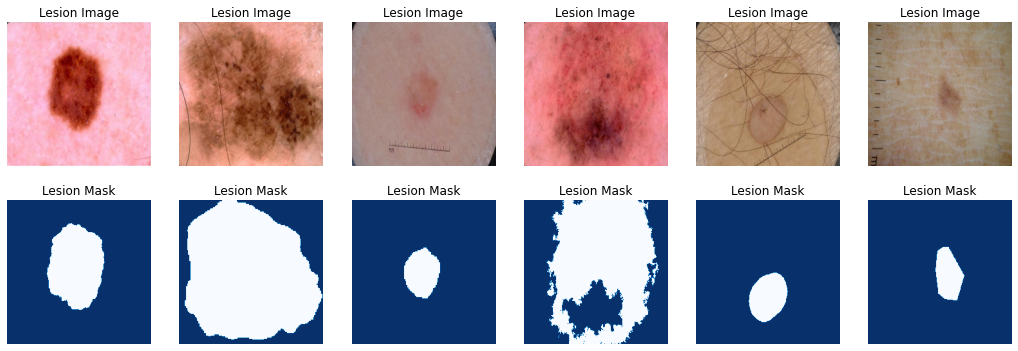

In [6]:
def denormalization(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean 
    return img

def show_subset(images, masks, n):
    images = images.numpy() 
    masks = masks.numpy()
    
    fig, ax = plt.subplots(2, n, figsize=(n*3,6))
    for i in range(n):
        ax[0, i].imshow(denormalization(np.rollaxis(images[i,:,:,:],0,3)), vmin=0, vmax=1, cmap='gray') # np.rollaxis(images[i,:,:,:],0,3)) to swap channel axes to channels last
        ax[1, i].imshow(masks[i,:,:], vmin=0, vmax=1, cmap='Blues_r')
        ax[0, i].set_title('Lesion Image')
        ax[1, i].set_title('Lesion Mask')
        ax[1, i].axis('off')
        ax[0, i].axis('off')
    plt.show()

dataiter = iter(valid_loader) # get iterator of train_loader 
images, masks = dataiter.next() # get a random batch of train_loader iterator
show_subset(images, masks, n=6) # show images, masks subset of size n of batch

# 3 Modellerstellung

Als nächstes wird ein [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) Modell erstellt. In der Variable `MODEL_DIR` ist das Verzeichnis angegeben, in dem Checkpoints  der trainierten Modellgewichte gespeichert werden und beim Fortsetzen des Trainings über die Variable `MODEL_CHECKPOINTS` geladen werden können.

Über die Funktion `Unet()` des Packages [segmentation-models-pytorch 0.2.1](https://github.com/qubvel/segmentation_models.pytorch) können U-Net Modelle mit unterschiedlichen CNN Backbones als U-Net Encoder geladen werden. Das zu verwendende CNN-Backbone wird über den Parameter `encoder_name` definiert, wobei zusätzlich über den Parameter `encoder_weights` angegeben werden kann, ob das CNN-Backbone mit vortrainierten Gewichten geladen werden soll (z.B. ImageNet). Eine Liste aller möglichen Backbones ist im GitHub-Repository verfügbar. In diesem Beispiel wird ein mit ImageNet vortrainiertes EfficientNet-B0 als U-Net-Encoder verwendet.

Da es sich bei den Hautbildern um RGB-Farbbilder handelt, ist die Anzahl der Eingangskanäle `in_channels` auf 3 zu setzen. Das Ziel des U-Net-Modells ist es, automatisch eine binäre Segmentierungsmaske für die Hautbilder zu erstellen, mit den Pixelwerten 0=Hintergrund und 1=Lesion. Daher ist die Anzahl der Vorhersageklassen der Ausgabeschicht `classes` auf 1 zu setzen. 

Mit Hilfe des Packages `torchinfo` und der Funktion `summary()` kann die Modellstruktur des U-Nets übersichtlich dargestellt werden. Alternativ kann dies auch mit der Python-Funktion `print()` erfolgen. 

In [7]:
print("Creating model")
print("model_dir: ", os.path.realpath(MODEL_DIR))
os.makedirs(MODEL_DIR, exist_ok=True)

# Create model
# see https://github.com/qubvel/segmentation_models.pytorch
model = smp.Unet(encoder_name='efficientnet-b0',
                 encoder_weights='imagenet',
                 in_channels=3,
                 classes=1)

MODEL_CHECKPOINTS = None # Specifying model checkpoints for continuing training, e.g. f"{MODEL_DIR}/model_epoch1.pth"
if MODEL_CHECKPOINTS: # load model checkpoints if available
    model.load_state_dict(torch.load(MODEL_CHECKPOINTS, map_location="cpu"))

print(summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), depth=5))
print(model)

print("Model successfully created")

Creating model
model_dir:  /home/user01/02_segmentation/models/segmentation


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to //home/user01/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Layer (type:depth-idx)                                  Output Shape              Param #
Unet                                                    [16, 1, 224, 224]         --
├─EfficientNetEncoder: 1-1                              [16, 3, 224, 224]         412,160
│    └─Conv2dStaticSamePadding: 2-1                     [16, 32, 112, 112]        864
│    │    └─ZeroPad2d: 3-1                              [16, 3, 225, 225]         --
│    └─BatchNorm2d: 2-2                                 [16, 32, 112, 112]        64
│    └─MemoryEfficientSwish: 2-3                        [16, 32, 112, 112]        --
│    └─ModuleList: 2                                    --                        --
│    │    └─MBConvBlock: 3-2                            [16, 16, 112, 112]        --
│    │    │    └─Conv2dStaticSamePadding: 4-1           [16, 32, 112, 112]        288
│    │    │    │    └─ZeroPad2d: 5-1                    [16, 32, 114, 114]        --
│    │    │    └─BatchNorm2d: 4-2                    

### Verlustfunktion
Maschinelles Lernen ist im Grunde eine Optimierungsaufgabe, die darauf abzielt, einen Fehler zwischen Vorhersagen eines Modells z.B. einem Neuronalen Netz und tatsächlichen Beobachtungen aus einem Datensatz zu minimieren. Um den Fehler zwischen Modellvorhersagen und tatsächlichen Beobachtungen zu quantifizieren, ist eine Verlustfunktion erforderlich. Weichen die Modellvorhersagen zu stark von den tatsächlichen Beobachtungen ab, nimmt die Verlustfunktion einen sehr hohen Wert an, den sogenannten Verlust (eng. loss). Das Ziel des Trainingsprozesses ist es nun, diesen Verlust schrittweise zu minimieren, indem die Gewichte des Neuronalen Netzes mit Hilfe von Optimierungsalgorithmen angepasst werden.

Bei Segmentierungsaufgaben kann der Verlust pixelweise zwischen der durch das Modell vorhergesagten Segmentierungsmaske und der Ground-Truth-Segmentierungsmaske auf unterschiedliche Weise quantifiziert werden. Da die Segmentierungsaufgabe im Grunde ein Klassifizierungsproblem für jeden Pixel der Segmentierungsmaske darstellt, können gängige Verlustfunktionen zur Klassifizierung verwendet werden (z.B. die Kreuzentropie) und der Verlust für jeden Pixel einzeln ausgewertet und anschließend über alle Pixel gemittelt werden. Dies kann jedoch ein Problem darstellen, wenn die verschiedenen Pixelanteile der Klassen im Bild unausgewogen verteilt sind, da das Training von der am häufigsten vertretenen Klasse dominiert würde. Von diesem Problem ausgenommen sind Verlustfunktionen (z.B. der [Dice-Loss](https://arxiv.org/abs/2006.14822)), die im Wesentlichen die Überlappung zwischen der Segmentierungsmaske der Modellvorhersage und der Grundwahrheit quantifizieren.

In [8]:
# Loss functions from segmentation_models.pytorch, see: https://github.com/qubvel/segmentation_models.pytorch

# loss function based on Dice-Score
loss_function = DiceLoss(mode='binary', from_logits=True) 

### Optimizer
Optimizer sind Optimierungsalgorithmen und für die Anpassung der Gewichte im Trainingsprozess zuständig. PyTorch implementiert bereits eine Reihe von unterschiedlichen [Optimizern](https://pytorch.org/docs/stable/optim.html#module-torch.optim) mit unterschiedlichen Optimierungsverfahren. Wir werden für unser Training den [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) Optimizer nutzen.

Ein wichtiger Parameter der Optimierer ist die Lernrate, mit der das Ausmaß der Gewichtsanpassung pro Trainingsschritt angepasst werden kann. Übliche Lernraten liegen zwischen `0.001` und `0.00001`. Größere Lernraten ermöglichen ein schnelleres Training, können aber auch zu problematischen Sprüngen im Lösungsraum und zu Divergenz (gleichbleibend schlechte Fehler) führen. Kleinere Lernraten sind für das Fine-Tuning geeignet.

__Aufgabe:__ Ersetzen Sie die Variable `LEARN_RATE` durch eine geeignete Lernrate. Experimentieren Sie mit unterschiedlichen Lernraten. 

In [9]:
# optimizer 
LEARN_RATE = 1e-05
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)

### Kennzahlen und Logs zur Überwachung des Trainingsfortschritts

Neben dem Verlust können weitere [Kennzahlen](https://de.wikipedia.org/wiki/Beurteilung_eines_bin%C3%A4ren_Klassifikators) bei der Bewertung des Trainingsfortschritts eines Neuronalen Netzwerkes hilfreich sein. Bei der Segmentierung wird der Überlappungsgrad Intersection-over-Union (IoU) häufig als Maß für die Segmentierungsqualität verwendet. Die IoU-Metrik, auch Jaccard-Index genannt, quantifiziert den prozentualen Anteil der Überlappung zwischen der Segmentierungsmaske der Grundwahrheit und der Segmentierungsmaske aus der Modellvorhersage, oder einfacher ausgedrückt, die Anzahl der Pixel, die die Segmentierungsmasken gemeinsam haben, geteilt durch die Gesamtzahl der Pixel beider Masken.

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png" width="300" />
Quelle: https://en.wikipedia.org/wiki/Jaccard_index


Das Packages [TorchMetric](https://torchmetrics.readthedocs.io/en/stable/) bietet eine komfortable Lösung zur Erfassung von unterschiedlichen Metriken während des Trainingsprozesses.

Zur späteren Visualisierung des Trainingsprozesses ist es sinnvoll, Verluste und andere Metriken während des Trainings zu protokollieren. In diesem Beispiel werden diese während des Trainings im Dictonary `logs` gespeichert.  

In [10]:
loss_metric = MeanMetric(full_state_update=False)
iou_metric = JaccardIndex(num_classes=2, threshold=0.5, average='macro', full_state_update=False)

logs = {'loss': [], 'iou': [], 'val_loss': [], 'val_iou': []}

## 3.1 Modell-Training

Damit PyTorch das Training auf der GPU durchführt, müssen alle wichtigen Komponenten des Trainingsprozesses, wie das Modell selbst, die Verlustfunktion, Metriken, Bilder und Masken aus dem DataLoader usw. in den VRAM der GPU verschoben werden. Dies ist über die Funktion `.to(device)` möglich. `device` ist eine Variable, die den String "cuda" annimmt, wenn eine GPU verfügbar ist, andernfalls den String "cpu" und das Training findet nicht auf einer GPU statt.

In [11]:
device = ("cuda" if torch.cuda.is_available() else "cpu") 

# move model, loss and metrics to GPU-VRAM if available
model = model.to(device)
loss_function = loss_function.to(device)
loss_metric = loss_metric.to(device)
iou_metric = iou_metric.to(device)

Das eigentliche Training findet nun nachfolgend statt und kann einige Zeit in Anspruch nehmen. Ob der Kernel im Hintergrund noch aktiv ist, lässt sich an dem Kreis oben rechts erkennen - solange der Kreis gefüllt ist, läuft das Skript noch.

Das Training erfolgt Epochenweise `for epoch in range(NUM_EPOCHS):`, wobei eine Trainingsepoche dem Durchlauf aller Minibatches des Trainingsdatensatzes entspricht. Über die Variable `NUM_EPOCHS` kann die Anzahl der Trainingsepochen angegeben werden.

Eine Trainingsepoche besteht nun aus zwei Phasen, der Trainingsphase und der Validierungsphase. Zu Beginn einer Trainingsphase wird zunächst das Modell in den Trainingsmodus versetzt `model.train()` und zuvor gespeicherte Kennzahlen werden zurückgesetzt `loss_metric.reset()`. Anschließend wird über die Minibatches des Trainingsdatensatzes iteriert `for i, (images, masks) in enumerate(train_loader, 0)`, die Bilder und Masken des Minibatches in den GPU-VRAM verschoben `images.to(device) ...`, zuvor gespeicherte Gradienteninformationen des Optimizers gelöscht `optimizer.zero_grad()`, die Bilddaten des Minibatches an das Modell zur Vorhersage übergeben `outputs = model(images)`, der Verlust zwischen den Masken der Modellvorhersage und Masken der Grundwahrheiten des Minibatches ermittelt `loss_function(y_pred=outputs, y_true=masks)`, der Verlust über die Modellgewichte zurückpropagiert (Gradienteninformation werden ermittelt) `loss.backward()`, die Modellgewichte mit dem Optimierer entsprechend der Gradienteninformation angepasst `optimizer.step()` und Kennzahlen für diesen Trainingsschritt ermittelt `... iou_of_batch = iou_metric(predictions, masks)`.

Wenn alle Minibatches im Trainingsdatensatz durchlaufen wurden, ist eine Trainingsepoche abgeschlossen. Im Anschluss an die Trainingsepoche wird der gemittelte Verlust `loss_metric.compute() ...` und die gemittelten Kennzahlen für die gesammte Trainingsepoche berechnet und in `logs` gespeichert.

Im Anschluss an die Trainingsphase beginnt die Validierungsphase. In der Validierungsphase werden Verlust und Metriken anhand von "ungesehenen" Validierungsdaten ermittelt. Wichtig! Es findet keine Anpassung der Modellgewichte statt. Die Validierungsphase unterscheidet sich nur geringfügig von der zuvor beschriebenen Trainingsphase. Zunächst wird das Modell in den Validierungsmodus `model.eval()` versetzt, die Metriken der vorangegangenen Trainingsphase werden zurückgesetzt und dann über alle Minibatches des Validierungsdatensatzes iteriert, die Bilddaten dem Modell zur Vorhersage übergeben, Verlust und Kennzahlen bestimmt und schlussendlich in `logs` gespeichert. 

Zum Ende jeder Trainingsepoche werden die Modellgewichte der aktuellen Epoche `torch.save(model.state_dict(), ...)` gespeichert sowie die ermittelten Trainings-/ Validierungsverluste und -Kennzahlen in einer CSV-Datei gesichert.

In [12]:
NUM_EPOCHS = 20 # NUM_EPOCHS was defined earlier 

print("Start training")

#iterate over epochs
for epoch in range(NUM_EPOCHS):
    
    # progress bar [optional]
    kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch, num_epochs=NUM_EPOCHS, width=24, always_stateful=False)
    
    ############################## training phase ####################################
    # set model to training phase
    model.train()
    
    # reset metrics for training phase
    loss_metric.reset()
    iou_metric.reset()
    
    # iterate over training batches 
    for i, (images, masks) in enumerate(train_loader, 0):
        # move training batch with labels to GPU-VRAM 
        images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)

        # zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)

        # forward pass
        outputs = model(images).squeeze(dim=1)
        loss = loss_function(y_pred=outputs, y_true=masks)
        
        # backward pass 
        loss.backward()
        optimizer.step()
        
        # update running metrics
        loss_of_batch = loss_metric(loss)
        predictions = torch.sigmoid(outputs)
        iou_of_batch = iou_metric(predictions, masks)

        # Update progress bar [optional]
        kbar.update(i, values=[("loss", loss_of_batch), ("IoU", iou_of_batch)])
    
    # learning rate scheduler step 
    #lr_scheduler.step()
    
    # calculate training metric results for the epoch and append results to logs
    epoch_loss = loss_metric.compute().detach().cpu().item()
    epoch_iou = iou_metric.compute().detach().cpu().item()
    logs['loss'].append(epoch_loss)
    logs['iou'].append(epoch_iou)
    
          
    ############################## validation phase ####################################
    # set model to validation phase
    model.eval()
    
    # reset metrics for validation phase
    loss_metric.reset()
    iou_metric.reset()
    
    # prevents PyTorch from gathering gradients to speed up validation phase
    with torch.no_grad():
        # iterate over validation batches 
        for i, (images, masks) in enumerate(valid_loader, 0):
            # move validation batch with labels to GPU-VRAM 
            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)

            # forward pass
            outputs = model(images).squeeze(dim=1)
            loss = loss_function(y_pred=outputs, y_true=masks)

            # update running metrics
            loss_of_batch = loss_metric(loss)
            predictions = torch.sigmoid(outputs)
            iou_of_batch = iou_metric(predictions, masks)

        # calculate validation metric results for the epoch and append results to logs
        epoch_val_loss = loss_metric.compute().detach().cpu().item()
        epoch_val_iou = iou_metric.compute().detach().cpu().item()
        logs['val_loss'].append(epoch_val_loss)
        logs['val_iou'].append(epoch_val_iou)
        
        # Add validation results to progress bar [optional]
        kbar.add(1, values=[("val_loss", epoch_val_loss), ("val_IoU", epoch_val_iou)])
        
    ############################## save epoch results ############################ 
    #save model weights for the epoch
    torch.save(model.state_dict(), f'{MODEL_DIR}/model_epoch{epoch}.pth')
    
    # save logs for the epoch as csv
    logs_as_df = pd.DataFrame(logs)
    logs_as_df.to_csv(f'{MODEL_DIR}/training_history.csv', index_label='epoch', sep=',', encoding='utf-8')
    
    
print(f"Finished training, model saved to: {MODEL_DIR}/model_epoch{epoch}.pth")

Start training
Epoch: 1/30
130/130 [========================] - 19s 147ms/step - loss: 0.6915 - IoU: 0.4425 - val_loss: 0.6426 - val_IoU: 0.5074
Epoch: 2/30
130/130 [========================] - 18s 139ms/step - loss: 0.6265 - IoU: 0.5472 - val_loss: 0.5659 - val_IoU: 0.6266
Epoch: 3/30
130/130 [========================] - 18s 138ms/step - loss: 0.5685 - IoU: 0.6314 - val_loss: 0.5160 - val_IoU: 0.7058
Epoch: 4/30
130/130 [========================] - 18s 135ms/step - loss: 0.5147 - IoU: 0.6989 - val_loss: 0.4634 - val_IoU: 0.7677
Epoch: 5/30
130/130 [========================] - 18s 137ms/step - loss: 0.4690 - IoU: 0.7486 - val_loss: 0.4138 - val_IoU: 0.7912
Epoch: 6/30
130/130 [========================] - 19s 143ms/step - loss: 0.4275 - IoU: 0.7811 - val_loss: 0.3808 - val_IoU: 0.8170
Epoch: 7/30
130/130 [========================] - 18s 137ms/step - loss: 0.4041 - IoU: 0.7915 - val_loss: 0.3558 - val_IoU: 0.8318
Epoch: 8/30
130/130 [========================] - 17s 133ms/step - loss: 0.3

Die Ausgabe des Trainingsskripts enthält die folgenden Informationen:

- `1/2301`: Der aktuell verarbeitete Minibatch. Die Gesamtzahl der Minibatches 2301 wird berechnet, indem die Anzahl aller Trainingsbilder durch die Batch-Größe geteilt wird: "36808 / 16 ~ 2301"
- `ETA: 1:55`: Erwartete Restzeit einer Trainingsepoche
- `417s 181ms/step`: Gesamtdauer der Trainingsepoche sowie durchschnittliche Dauer eines Trainingsschrittes
- `loss: 0.9618`: Mittlerer Verlust aller/ bereits verarbeiteten Minibatches der Trainingsdaten
- `accuracy: 0.6617`: Mittlere Accuracy aller/ bereits verarbeiteten Minibatches der Trainingsdaten
- `val_loss: 1.9990`: Mittelwert der Verluste aller Minibatches der Validierungsdaten (wird nur einmal pro Epoche generiert)
- `val_accuracy: 0.5227`: Mittelwert der Accuracy aller Minibatches der Validierungsdaten (wird nur einmal pro Epoche generiert)

Es ist wichtig, die Werte der Trainings- und Validierungsdaten zu vergleichen. Liegen diese Werte weit auseinander, so liegt ein Overfitting vor, d.h. die Trainingsdaten wurden auswendig gelernt.

<a id='visualization'></a>
## 3.2 Visualisierung des Trainings

Anhand der gespeicherten Verluste und weiteren Kennzahlen der Trainings- und Validierungsdaten im Dictonary `logs` kann der Trainingsprozess nachträglich visualisiert werden.

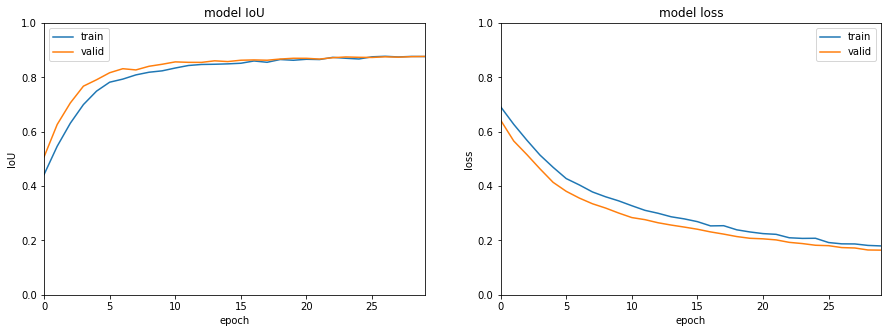

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# plot training history for accuracy
ax[0].plot(logs['iou'], label='train')
ax[0].plot(logs['val_iou'], label='valid')
ax[0].set_title('model IoU')
ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, NUM_EPOCHS-1)
ax[0].set_ylabel('IoU')
ax[0].set_xlabel('epoch')
ax[0].legend(loc='best')

# plot training history for loss
ax[1].plot(logs['loss'], label='train')
ax[1].plot(logs['val_loss'], label='valid')
ax[1].set_title('model loss')
ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, NUM_EPOCHS-1)
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='best')

fig.savefig(f'{MODEL_DIR}/training_history.png', dpi=100, format="png")
plt.show()

## 4 Modell-Evaluation

Bei der Modell-Evaluation soll nun überprüft werden, welche Segmentierungsgüte unserer trainiertes Modell auf ungesehenen Testdaten erzielt.

### Test Datensatz

Der Einfachheit halber werden im Folgenden die Validierungsdaten als Testdaten verwendet. __Wichtig!__ Dieses Vorgehen ist nicht optimal, da unsere Validierungsdaten aufgrund von Parameteranpassungen der Lernrate o.ä. nicht mehr unabhängig sind und es theoretisch zu einem Overfitting auf den Validierungsdaten kommen kann. 
Damit die Bewertung der Segmentierungsgüte des Modells aussagekräftig bleibt, sollte vor dem Modelltraining und der Parameteranpassung eine kleine Teilmenge des Datensatzes als unabhängige Testdaten zurückgehalten werden. 

Das Laden und Vorverarbeiten der Testdaten erfolgt auf die gleiche Weise wie in Abschnitt 2.

In [14]:
# albumentation pre-processing pipeline for the test images 
test_transform = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

# create test dataset and loader
test_dataset = ISIC2018Task1_Dataset(valid_image_files, valid_mask_files, test_transform)
test_loader = DataLoader(dataset=test_dataset, 
                          shuffle=True, # shuffle only for visualization purposes else set to False  
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multiprocessing
                          pin_memory=True)

print(f'Found {len(valid_dataset)} test images')

Found 519 test images


### Inferenz

Inferenz ist der Prozess, bei dem ein trainiertes Modell verwendet wird, um Vorhersagen für zuvor ungesehene Daten zu treffen. Zur Interpretation der vorhergesagten Segmentierungsmaske des Modells werden die jeweiligen pixelweisen Aktivierungen der Ausgangsneuronen mittels Sigmod-Aktivierung (binärer Fall) in Vorhersagewahrscheinlichkeiten des Intervalls [0,1] umgewandelt. Anschließend wird pixelweise anhand der Vorhersagewahrscheinlichkeiten der Segmentierungsmaske entschieden, ob ein Pixel < 0.5 zur Klasse "background" oder > 0.5 zur Klasse "lesion" gehört. 

Um anschließend die Segmentierungsqualität des Modells zu bestimmen, werden verschiedene Metriken (IoU, Recall, Precision) und eine Konfusionsmatrix für die Segmentierungsmasken der Modellvorhersagen im Vergleich zu den Grundwahrheiten ermittelt. 

In [15]:
# test metrics for evaluating the classification performance of the model 
test_iou_metric = JaccardIndex(num_classes=2, threshold=0.5, average='macro', full_state_update=False).to(device)
test_recall_metric = Recall(num_classes=2, average=None, multiclass=True, mdmc_average='samplewise').to(device)
test_precision_metric = Precision(num_classes=2, average=None, multiclass=True, mdmc_average='samplewise').to(device)
confusion_matrix_metric = ConfusionMatrix(num_classes=2, normalize='true', threshold=0.5).to(device)

# iterate over testdata batches (tqdm only for progress bar)
for (images, masks) in tqdm.tqdm(test_loader):
    # transfer images to the GPU for model inference
    images, masks = images.to(device), masks.to(device) 

    # model inference for each image in the batch 
    outputs = model(images).squeeze(dim=1)
    prediction_probabilities = torch.sigmoid(outputs) # compute the model prediction probabilities from logit outputs for all classes
    prediction_masks = (prediction_probabilities > 0.5).int() # threshold prediction probabilities: if > 0.5 class 1 (lesion) else class 0 (background)
    
    # update running test metrics
    test_iou_metric.update(prediction_masks, masks)
    test_recall_metric.update(prediction_masks, masks)
    test_precision_metric.update(prediction_masks, masks)
    confusion_matrix_metric.update(prediction_masks, masks)
    
# calculate test metric results
test_iou = test_iou_metric.compute().detach().cpu().item()
test_recall = test_recall_metric.compute().detach().cpu().numpy()
test_precision = test_precision_metric.compute().detach().cpu().numpy()
test_confusion_matrix = confusion_matrix_metric.compute().detach().cpu().numpy()

print(f"Testdata evaluation results:\nIoU: {test_iou:.5f}\n{pd.DataFrame({'Recall': test_recall, 'Precision': test_precision}, index = ['background', 'lesion'])}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 13.93it/s]

Testdata evaluation results:
IoU: 0.87701
              Recall  Precision
background  0.954859   0.967053
lesion      0.919177   0.863764


### Konfusionsmatrix

Eine [Konfusionsmatrix](https://en.wikipedia.org/wiki/Confusion_matrix) ist ebenfalls hilfreich für die Interpretation der Segmentierungsgüte eines Modells. Mit ihr lässt sich feststellen, welche Klassen des Datensatzes vom Modell häufig richtig oder falsch segmentiert werden sowie welche Klassen am häufigsten verwechselt werden. 

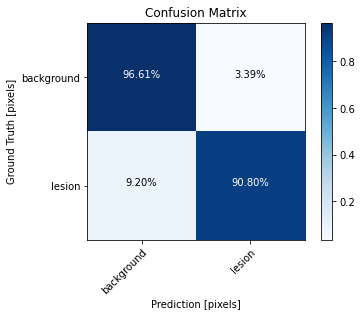

In [16]:
# confusion matrix computed earlier
cm = test_confusion_matrix
#print(f"confusion matrix:\n{cm}")

# plot confusion matrix
fig, ax = plt.subplots(1,1)
cm_fig = ax.imshow(cm, interpolation='nearest', cmap="Blues") # plot confusion matrix background color 
fig.colorbar(cm_fig, ax=ax) # add confusion matrix color bar
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['background', 'lesion'], rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(['background', 'lesion'])
ax.set_xlabel('Prediction [pixels]')
ax.set_ylabel('Ground Truth [pixels]') 
ax.set_title("Confusion Matrix")

# plot confusion matrix values
for ix, iy in np.ndindex(cm.shape):
    ax.text(iy, ix, f"{100*cm[ix, iy]:.2f}%", horizontalalignment="center", color="white" if cm[ix, iy] > cm.max() / 2.0 else "black")
    #ax.text(iy, ix, cm[ix, iy], horizontalalignment="center", color="white" if cm[ix, iy] > cm.max() / 2.0 else "black")    


fig.savefig(f'{MODEL_DIR}/confusion_matrix.png', dpi=100, format="png")
plt.show()    

### Inferenz mit Visualisierung

Es folgt die Inferenz für einen Minibatch der Testdaten, mit anschließender Visualisierung der Masken der Grundwahrheiten und Modellvorhersage für jedes Bild eines Minibatchs.

Diese Zelle kann mehrfach ausgeführt werden, um das Ergebnis eines zufälligen Batches der Testdaten darzustellen.

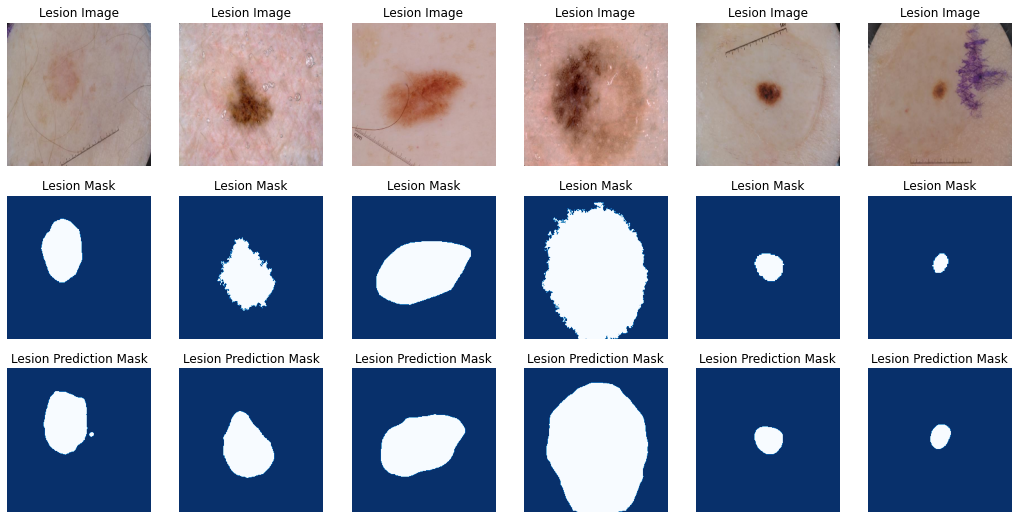

In [18]:
def denormalization(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean 
    return img

def show_predictions(images, masks, prediction_masks, n=6):
    images = images.cpu().numpy() 
    masks = masks.cpu().numpy()
    prediction_masks = prediction_masks.cpu().numpy()
    
    fig, ax = plt.subplots(3, n, figsize=(n*3,9))
    for i in range(n):
        ax[0, i].imshow(denormalization(np.rollaxis(images[i,:,:,:],0,3)), vmin=0, vmax=1, cmap='gray') # np.rollaxis(images[i,:,:,:],0,3)) to swap channel axes to channels last
        ax[1, i].imshow(masks[i,:,:], vmin=0, vmax=1, cmap='Blues_r')
        ax[2, i].imshow(prediction_masks[i,:,:], vmin=0, vmax=1, cmap='Blues_r')
        ax[0, i].set_title('Lesion Image')
        ax[1, i].set_title('Lesion Mask')
        ax[2, i].set_title('Lesion Prediction Mask')
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')
    plt.show()

dataiter = iter(test_loader) # get iterator of test_loader 
images, masks = dataiter.next() # get a random batch of test_loader iterator

# transfer images to the GPU for model inference
images = images.to(device) 

# model inference for each image in the batch 
outputs = model(images) 
prediction_probabilities = torch.sigmoid(outputs) # compute the model prediction probabilities from logit outputs for all classes
prediction_masks = (prediction_probabilities > 0.5).float().squeeze(1) # threshold prediction probabilities: if > 0.5 class 1 (lesion) else class 0 (background)

show_predictions(images, masks, prediction_masks, n=6) # show n images, masks, predictions of batch